# Mafia Match Outcome Prediction — Final Educational Notebook

**Goal.** Predict the probability that a team wins a mafia game from pre-game and contextual features.

**What this notebook shows:**
1. Data preparation (cleaning, feature matrix, target).
2. Train/Calibrate/Evaluate baseline and gradient boosting models (LightGBM, CatBoost).
3. Blend models and compare with metrics.
4. Educational plots:
   - Correlation heatmap (top features)
   - ROC curves (all models + blend)
   - Calibration curve
   - Feature importance (LGBM)
   - Metrics comparison bar chart

**Validation plan.** We use a time-aware split: the last 15% of rows as **holdout**. From the remaining 85%, we use:
- **Train** (inner train) to fit models.
- **Calibration** (dev) to calibrate predicted probabilities (Platt sigmoid).
We report **LogLoss**, **ROC-AUC**, and **Brier score** on the **holdout** set.


## 1) Data preparation (cleaning, feature matrix, target)


### 1.1 Environment & Imports

If something is missing, install via the first cell. Then import everything we need.

In [2]:
# If needed, uncomment to install packages
# !pip install -q lightgbm catboost scikit-learn optuna matplotlib pandas numpy

import pandas as pd
import numpy as np
from pathlib import Path

# Modeling & metrics
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.base import clone
from sklearn.calibration import CalibratedClassifierCV

# --- Core ---
import os
from pathlib import Path
import numpy as np
import pandas as pd

# --- Models ---
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier

# --- Metrics & model utilities ---
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    log_loss, roc_auc_score, brier_score_loss, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- Plots ---
import matplotlib.pyplot as plt

# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)

# --- Paths ---
DATA_CSV = Path("cleaned/mafia_clean.csv") 
OUT_DIR  = Path("cleaned"); OUT_DIR.mkdir(exist_ok=True, parents=True)

# --- Display options ---
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)



### 1.2 Configuration & Data Load

- **Input:** a cleaned per-player table (one row per player per game).  
  Columns required (min): `id, game_id, player_id, role, team, place, game_points, team_win`  
- **Assumptions:** each game has **10 players**; exactly **one team wins** (7 winners if citizens, 3 if mafia).  
- **Time proxy:** `id` increases with time.


In [3]:

df = pd.read_csv(DATA_CSV)
print("Loaded:", df.shape, "columns:", len(df.columns))
assert {'id','game_id','player_id','role','team','game_points','team_win'}.issubset(df.columns), \
    "Missing required columns in the cleaned dataset."

# Basic coercions
df['id'] = pd.to_numeric(df['id'], errors='coerce').astype('int64')
df['game_id'] = pd.to_numeric(df['game_id'], errors='coerce').astype('int64')
df['player_id'] = pd.to_numeric(df['player_id'], errors='coerce').astype('int64')
df['team_win'] = pd.to_numeric(df['team_win'], errors='coerce').astype('int8')
df['team'] = df['team'].astype('category')
df['role'] = df['role'].astype('category')

# Seat/position optional column name normalization (if present)
if 'place' in df.columns:
    df['place'] = pd.to_numeric(df['place'], errors='coerce').fillna(0).astype('int16')


C:\Users\user\AppData\Local\Temp\ipykernel_5860\1206575592.py:1: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_CSV)


Loaded: (802820, 21) columns: 21


### 1.3 Helper Utilities

Small helpers for quantiles and sanity checks.

In [4]:
def q25(x): return np.nanpercentile(x, 25)
def q75(x): return np.nanpercentile(x, 75)

def sanity_assert_two_rows_per_game(team_tall):
    cnt = team_tall.groupby('game_id').size().value_counts()
    print("Rows per game distribution:\n", cnt.head())
    assert 2 in cnt.index.tolist(), "Every game should have exactly 2 rows (one per team)."

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins+1)
    inds = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = inds == b
        if mask.sum() == 0: 
            continue
        conf = y_prob[mask].mean()
        acc  = y_true[mask].mean()
        ece += (mask.mean()) * abs(acc - conf)
    return ece


### 1.4 Feature Engineering (Player-level)

We compute **pre-game** features only (no leakage):
- **Temporal Elo with decay** (global, by side, by role)
- **Side & role** rolling performance
- **Breaks/freshness** via id gaps
- **Role-specific history** (experience and WR on that role)
- **Same-team synergy** & **Enemy familiarity**
- **Streaks** (win/loss)
- **Meta eras** (bucket by id)


#### 1.4.1 Meta eras & gap features
- `meta_period`: bucket `id` into eras to capture rule changes.
- `gap_id` per player → `gap_id_clipped` (bounded) and `long_break_flag`.


In [5]:
# Meta eras
bins   = [0, 200_000, 400_000, 600_000, 800_000, 1_000_000_000]
labels = [1, 2, 3, 4, 5]
df['meta_period'] = pd.cut(df['id'], bins=bins, labels=labels, include_lowest=True).astype('int8')

# Gap per player (id as time proxy)
df = df.sort_values(['player_id','id']).copy()
df['gap_id'] = df.groupby('player_id')['id'].diff().fillna(0).astype('int64')
df['gap_id_clipped'] = np.clip(df['gap_id'], 0, 5000).astype('int32')
GAP_THRESH = 381  # adjust via quantiles if desired
df['long_break_flag'] = (df['gap_id'] >= GAP_THRESH).astype('int8')

# Restore global order
df = df.sort_values('id').reset_index(drop=True)

#### 1.4.2 Temporal Elo with decay
We update Elo **after** each game. Each update is scaled by `exp(-gap/tau)` so **older inactivity** reduces update size.

In [6]:
def compute_elos(dfin, init=1500, k=24, tau=300.0):
    d = dfin.sort_values('id').copy()
    elo_global, elo_side, elo_role = {}, {}, {}
    last_seen = {}
    outs = []

    for gid, g in d.groupby('game_id', sort=False):
        cur = g.copy()
        cur['pre_elo']      = [elo_global.get(pid, init) for pid in cur['player_id']]
        cur['pre_elo_side'] = [elo_side.get((pid, team), init) for pid, team in zip(cur['player_id'], cur['team'])]
        cur['pre_elo_role'] = [elo_role.get((pid, role), init) for pid, role in zip(cur['player_id'], cur['role'])]

        maf_mask  = cur['team'].eq('mafia')
        mafia_mu  = cur.loc[maf_mask, 'pre_elo'].mean()
        citizen_mu= cur.loc[~maf_mask, 'pre_elo'].mean()
        exp_mafia = 1.0 / (1.0 + 10 ** ((citizen_mu - mafia_mu)/400))
        mafia_res = int(cur.loc[maf_mask, 'team_win'].iloc[0])

        for _, r in cur.iterrows():
            pid, side, role, rid = int(r['player_id']), r['team'], r['role'], int(r['id'])
            gap = rid - last_seen.get(pid, rid)
            decay = float(np.exp(-max(gap,0)/float(tau)))
            exp = exp_mafia if side=='mafia' else (1-exp_mafia)
            act = mafia_res if side=='mafia' else (1-mafia_res)
            delta = k * decay * (act - exp)

            elo_global[pid] = elo_global.get(pid,  init) + delta
            elo_side[(pid, side)] = elo_side.get((pid, side), init) + delta
            elo_role[(pid, role)] = elo_role.get((pid, role), init) + delta
            last_seen[pid] = rid

        outs.append(cur[['game_id','player_id','pre_elo','pre_elo_side','pre_elo_role']])

    elo_df = pd.concat(outs, ignore_index=True)
    return d.merge(elo_df, on=['game_id','player_id'], how='left')

work_players = compute_elos(df, init=1500, k=24, tau=300.0)


#### 1.4.3 Side-aware rolling win rates
We track recent **team win** rates for each player **on each side** separately (mafia/citizens).


In [7]:
def add_rolling_stats_side(df, windows=(5,20)):
    d = df.sort_values(['player_id','id']).copy()
    for side in ['mafia','citizens']:
        mask = d['team'].eq(side)
        d.loc[mask, f'roll5_win_rate_{side}']  = d.loc[mask].groupby('player_id')['team_win'].shift(1).rolling(windows[0], min_periods=1).mean().values
        d.loc[mask, f'roll20_win_rate_{side}'] = d.loc[mask].groupby('player_id')['team_win'].shift(1).rolling(windows[1], min_periods=1).mean().values
        d.loc[~mask, f'roll5_win_rate_{side}']  = 0.0
        d.loc[~mask, f'roll20_win_rate_{side}'] = 0.0
    return d

work_players = add_rolling_stats_side(work_players)

#### 1.4.4 Role-specific history
For each `(player, role)` compute:
- `games_in_role` (prior count)
- `win_rate_role_<role>_last{W}` for W in {5, 20, 50}


In [8]:
def add_role_history_stats(df, windows=(5,20,50)):
    d = df.sort_values(['player_id','role','id']).copy()
    out = []
    for (pid, role), g in d.groupby(['player_id','role'], sort=False):
        g = g.copy()
        past = g['team_win'].shift(1)
        g['games_in_role'] = np.arange(len(g), dtype=np.int32)
        for w in windows:
            g[f'win_rate_role_{role}_last{w}'] = past.rolling(w, min_periods=1).mean()
        out.append(g)
    return pd.concat(out, ignore_index=True).sort_values('id').reset_index(drop=True)

work_players = add_role_history_stats(work_players, windows=(5,20,50))


C:\Users\user\AppData\Local\Temp\ipykernel_5860\1064261818.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (pid, role), g in d.groupby(['player_id','role'], sort=False):


#### 1.4.5 Same-team synergy
Count prior **same-team co-plays** for all teammate pairs before this game, aggregate per team.

In [9]:
from itertools import combinations

def add_synergy_features(df):
    d = df.copy()
    game_order = (d.groupby('game_id')['id'].max().sort_values().index.tolist())
    pair_counts = {}
    out_rows = []

    for gid in game_order:
        g = d[d['game_id'] == gid]
        for team in ['mafia', 'citizens']:
            players = g.loc[g['team']==team, 'player_id'].dropna().astype(int).tolist()
            vals = [pair_counts.get((a,b,team), 0) for a,b in combinations(sorted(players), 2)] if len(players)>=2 else []
            s_mean = float(np.mean(vals)) if vals else 0.0
            s_max  = float(np.max(vals))  if vals else 0.0
            out_rows.append((gid, team, s_mean, s_max))
        # update after
        for team in ['mafia', 'citizens']:
            players = g.loc[g['team']==team, 'player_id'].dropna().astype(int).tolist()
            if len(players)>=2:
                for a,b in combinations(sorted(players), 2):
                    pair_counts[(a,b,team)] = pair_counts.get((a,b,team),0) + 1

    team_synergy = pd.DataFrame(out_rows, columns=['game_id','team','synergy_mean_team','synergy_max_team'])
    return d.merge(team_synergy, on=['game_id','team'], how='left')

work_players = add_synergy_features(work_players)


#### 1.4.6 Enemy familiarity (cross-team history)
Count how often each player has faced each opponent **before** this game. Aggregate per team.


In [10]:
from itertools import product

def add_enemy_familiarity_features(df):
    d = df.sort_values('id').copy()
    game_order = (d.groupby('game_id')['id'].max().sort_values().index.tolist())
    faced_counts = {}
    out_rows = []

    for gid in game_order:
        g = d[d['game_id'] == gid]
        maf = g[g['team']=='mafia']['player_id'].dropna().astype(int).tolist()
        cit = g[g['team']=='citizens']['player_id'].dropna().astype(int).tolist()

        pairs_maf = [faced_counts.get(tuple(sorted([a,b])), 0) for a,b in product(maf, cit)]
        pairs_cit = [faced_counts.get(tuple(sorted([a,b])), 0) for a,b in product(cit, maf)]

        def stats(vals):
            return (float(np.mean(vals)) if vals else 0.0,
                    float(np.max(vals))  if vals else 0.0)

        maf_mean, maf_max = stats(pairs_maf)
        cit_mean, cit_max = stats(pairs_cit)

        out_rows.append((gid,'mafia',    maf_mean, maf_max))
        out_rows.append((gid,'citizens', cit_mean, cit_max))

        for a,b in product(maf, cit):
            key = tuple(sorted([int(a),int(b)]))
            faced_counts[key] = faced_counts.get(key, 0) + 1

    fam = pd.DataFrame(out_rows, columns=['game_id','team','enemy_fam_mean_team','enemy_fam_max_team'])
    return d.merge(fam, on=['game_id','team'], how='left')

work_players = add_enemy_familiarity_features(work_players)


#### 1.4.7 Win/Loss streaks
Compute **pre-game** consecutive win and loss streak lengths for each player.


In [11]:
def add_streak_features(df):
    d = df.sort_values(['player_id','id']).copy()
    win_streaks, loss_streaks = [], []

    for pid, g in d.groupby('player_id', sort=False):
        prev = g['team_win'].shift(1).values
        w_stk = np.zeros(len(g), dtype=np.int16)
        l_stk = np.zeros(len(g), dtype=np.int16)
        cur_w = cur_l = 0
        for i, v in enumerate(prev):
            if np.isnan(v):
                cur_w = cur_l = 0
            else:
                if v == 1:
                    cur_w += 1; cur_l = 0
                else:
                    cur_l += 1; cur_w = 0
            w_stk[i] = cur_w
            l_stk[i] = cur_l
        win_streaks.append(pd.Series(w_stk, index=g.index))
        loss_streaks.append(pd.Series(l_stk, index=g.index))

    d['win_streak']  = pd.concat(win_streaks).sort_index()
    d['loss_streak'] = pd.concat(loss_streaks).sort_index()
    return d.sort_values('id').reset_index(drop=True)

work_players = add_streak_features(work_players)


#### 1.4.8 Games played to date (per player)
Cumulative count of past games per player (pre-game). Useful as a general “experience” signal.


In [12]:
def add_games_played_feature(df):
    d = df.sort_values(['player_id','id']).copy()
    # number of *prior* appearances (shift to avoid leakage)
    d['games_played'] = d.groupby('player_id').cumcount().astype('int32')
    return d.sort_values('id').reset_index(drop=True)

work_players = add_games_played_feature(work_players)


### 1.5 Team-Level Aggregation & Deltas

Aggregate player features to `(game_id, team)` rows. Then create **safe deltas**: `mafia − citizens`.  
We **never** delta the target or `meta_period`.


In [13]:
def build_team_agg(work_players, add_ratios=False, ratio_eps=1e-3):
    agg_funcs = {}

    def add_agg(col, funcs):
        if col in work_players.columns:
            agg_funcs[col] = funcs

    # Core
    add_agg('pre_elo', ['mean','std','min','max', q25, q75])
    add_agg('pre_elo_side', ['mean'])
    add_agg('pre_elo_role', ['mean'])
    add_agg('gap_id_clipped', ['mean','max'])
    add_agg('long_break_flag', ['sum'])
    add_agg('place', ['mean','std','min','max'])
    add_agg('games_played', ['mean','std','min','max'])  # if present

    # Optional blocks
    add_agg('win_streak', ['mean','max'])
    add_agg('loss_streak', ['mean','max'])
    add_agg('synergy_mean_team', ['mean'])
    add_agg('synergy_max_team',  ['mean'])
    add_agg('enemy_fam_mean_team', ['mean'])
    add_agg('enemy_fam_max_team',  ['mean'])
    add_agg('roll5_win_rate_mafia',  ['mean'])
    add_agg('roll20_win_rate_mafia', ['mean'])
    add_agg('roll5_win_rate_citizens',  ['mean'])
    add_agg('roll20_win_rate_citizens', ['mean'])
    if 'meta_period' in work_players.columns:
        agg_funcs['meta_period'] = ['first']

    base = work_players.groupby(['game_id','team']).agg(agg_funcs)
    base.columns = ['_'.join([str(x) for x in c if x not in (None,)]).replace('<function ','').replace('>','')
                    for c in base.columns]
    base = base.reset_index()

    # --- NEW: meta-period normalization for Elo stats (remove era drift) ---
    if 'meta_period_first' in base.columns:
        elo_cols = [c for c in base.columns if c.startswith('pre_elo_')]
        for col in elo_cols:
            # center within meta-period
            base[f'{col}_norm'] = base[col] - base.groupby('meta_period_first')[col].transform('mean')

    # Role-specific singletons/means
    full_idx = base.set_index(['game_id','team']).index
    # Role-specific singletons/means
    full_idx = base.set_index(['game_id','team']).index

    def single_role_stat(role, value_col, out_name):
        s = (work_players[work_players['role']==role]
             .groupby(['game_id','team'])[value_col].mean()).reindex(full_idx)
        s.name = out_name; return s

    def mean_role_stat(role, value_col, out_name):
        s = (work_players[work_players['role']==role]
             .groupby(['game_id','team'])[value_col].mean()).reindex(full_idx)
        s.name = out_name; return s

    pieces = [
        single_role_stat('don','pre_elo_role','don_pre_elo_role'),
        single_role_stat('sheriff','pre_elo_role','sheriff_pre_elo_role'),
        single_role_stat('don','place','don_place'),
        single_role_stat('sheriff','place','sheriff_place'),
        mean_role_stat('black','pre_elo_role','black_mean_pre_elo_role'),
        mean_role_stat('red','pre_elo_role','red_mean_pre_elo_role'),
        single_role_stat('don','games_in_role','don_games_in_role'),
        single_role_stat('sheriff','games_in_role','sheriff_games_in_role'),
        mean_role_stat('black','games_in_role','black_mean_games_in_role'),
        mean_role_stat('red','games_in_role','red_mean_games_in_role'),
        single_role_stat('don','win_rate_role_don_last20','don_wr20'),
        single_role_stat('sheriff','win_rate_role_sheriff_last20','sheriff_wr20'),
        mean_role_stat('black','win_rate_role_black_last20','black_mean_wr20'),
        mean_role_stat('red','win_rate_role_red_last20','red_mean_wr20'),
    ]
    role_feats = pd.concat(pieces, axis=1).reset_index()
    team_agg = base.merge(role_feats, on=['game_id','team'], how='left')

    # Label & time proxy
    labels  = work_players.groupby(['game_id','team'])['team_win'].max().rename('team_win_team')
    gmaxid  = work_players.groupby('game_id')['id'].max().rename('game_max_id')
    team_agg = team_agg.merge(labels, on=['game_id','team']).merge(gmaxid, on='game_id')

    # Safe deltas / ratios
    wide = team_agg.pivot(index='game_id', columns='team')
    wide.columns = [f"{a}__{b}" for a,b in wide.columns]
    wide = wide.reset_index()

    def side_cols(side): 
        return [c for c in wide.columns if c.endswith(f"__{side}") and c!='game_id']
    maf_cols = side_cols('mafia')

    delta = pd.DataFrame({'game_id': wide['game_id']})
    skip_prefixes = ('team_win_team','meta_period')
    for mcol in maf_cols:
        base_name = mcol[:-len("__mafia")]
        if base_name.startswith(skip_prefixes): 
            continue
        ccol = base_name + "__citizens"
        if ccol in wide.columns:
            delta[base_name + "__delta_maf_minus_cit"] = wide[mcol] - wide[ccol]
            if add_ratios:
                delta[base_name + "__ratio_maf_over_cit"] = (wide[mcol] + ratio_eps) / (wide[ccol] + ratio_eps)

    team_tall = team_agg.merge(delta, on='game_id', how='left')

    # --- NEW: a few safe interactions (helps tree models separate regimes) ---
    def safe_mul(a, b): 
        return (team_tall.get(a) if a in team_tall else 0) * (team_tall.get(b) if b in team_tall else 0)

    def safe_diff(a, b): 
        return (team_tall.get(a) if a in team_tall else 0) - (team_tall.get(b) if b in team_tall else 0)

    # Names used below exist after delta creation; if any is missing in your run, it's treated as 0
    team_tall['elo_synergy_product'] = safe_mul('pre_elo_mean__delta_maf_minus_cit',
                                                'synergy_mean_team_mean__delta_maf_minus_cit')
    team_tall['elo_enemy_gap']       = safe_diff('pre_elo_mean__delta_maf_minus_cit',
                                                'enemy_fam_mean_team_mean__delta_maf_minus_cit')
    team_tall['elo_streak_mix']      = safe_mul('pre_elo_mean__delta_maf_minus_cit',
                                                'win_streak_mean__delta_maf_minus_cit')

    return team_tall

team_tall = build_team_agg(work_players, add_ratios=False)  # ratios often redundant
sanity_assert_two_rows_per_game(team_tall)


Rows per game distribution:
 2    80282
Name: count, dtype: int64


### 1.6 Feature Selection

We include **team-only** features and **deltas**. We **exclude** label-like columns.
Then we create **time-aware** train/cal/test splits (70/15/15 by `game_max_id`).

In [14]:
team_only = [c for c in team_tall.columns if c.startswith((
    'pre_elo_', 'gap_id_clipped_', 'long_break_flag_', 'place_',
    'win_streak_', 'loss_streak_', 'synergy_mean_team_', 'synergy_max_team_',
    'enemy_fam_', 'games_played_', 
    'don_pre_elo_role', 'sheriff_pre_elo_role', 'black_mean_pre_elo_role', 'red_mean_pre_elo_role',
    'don_games_in_role', 'sheriff_games_in_role', 'black_mean_games_in_role', 'red_mean_games_in_role',
    'don_wr20', 'sheriff_wr20', 'black_mean_wr20', 'red_mean_wr20',
    'meta_period_first'
))]
delta_feats = [c for c in team_tall.columns if c.endswith('__delta_maf_minus_cit')]

# NEW: explicitly add our interactions and meta-normalized Elo columns
extra_feats = [c for c in ['elo_synergy_product','elo_enemy_gap','elo_streak_mix']
               if c in team_tall.columns]
meta_norm_feats = [c for c in team_tall.columns if c.endswith('_norm')]

forbidden_tokens = {'team_win','team_win_team'}
USED_FEATS = [c for c in sorted(set(team_only + delta_feats + extra_feats + meta_norm_feats))
              if not any(tok in c for tok in forbidden_tokens)]

In [15]:
USED_FEATS

['black_mean_games_in_role',
 'black_mean_games_in_role__delta_maf_minus_cit',
 'black_mean_pre_elo_role',
 'black_mean_pre_elo_role__delta_maf_minus_cit',
 'black_mean_wr20',
 'black_mean_wr20__delta_maf_minus_cit',
 'don_games_in_role',
 'don_games_in_role__delta_maf_minus_cit',
 'don_place__delta_maf_minus_cit',
 'don_pre_elo_role',
 'don_pre_elo_role__delta_maf_minus_cit',
 'don_wr20',
 'don_wr20__delta_maf_minus_cit',
 'elo_enemy_gap',
 'elo_streak_mix',
 'elo_synergy_product',
 'enemy_fam_max_team_mean',
 'enemy_fam_max_team_mean__delta_maf_minus_cit',
 'enemy_fam_mean_team_mean',
 'enemy_fam_mean_team_mean__delta_maf_minus_cit',
 'game_max_id__delta_maf_minus_cit',
 'games_played_max',
 'games_played_max__delta_maf_minus_cit',
 'games_played_mean',
 'games_played_mean__delta_maf_minus_cit',
 'games_played_min',
 'games_played_min__delta_maf_minus_cit',
 'games_played_std',
 'games_played_std__delta_maf_minus_cit',
 'gap_id_clipped_max',
 'gap_id_clipped_max__delta_maf_minus_cit'

## 2) Setup & Data

### 2.1 Helper Functions (Code)

In [16]:
def metrics_all(y_true, p_prob):
    """Return LogLoss, ROC-AUC, and Brier score in a dict."""
    return {
        "LogLoss": float(log_loss(y_true, p_prob)),
        "AUC": float(roc_auc_score(y_true, p_prob)),
        "Brier": float(brier_score_loss(y_true, p_prob)),
    }

def print_metrics(title, y_true, p_prob):
    m = metrics_all(y_true, p_prob)
    print(f"{title}\nLogLoss: {m['LogLoss']:.10f}\nAUC: {m['AUC']:.10f}\nBrier: {m['Brier']:.10f}\n")
    return m

def train_cal_split(dev_size, cal_frac=0.15, seed=SEED):
    """Given dev_size rows [0..dev_size-1], split into inner train and calibration by last 15% (time-aware)."""
    n_cal = int(round(dev_size * cal_frac))
    idx_cal = np.arange(dev_size - n_cal, dev_size)
    idx_tr  = np.arange(0, dev_size - n_cal)
    return idx_tr, idx_cal


### 2.2 Load Data & Define Target

In [17]:
X = team_tall[USED_FEATS].fillna(0)
y = team_tall['team_win_team'].astype(int).values
groups = team_tall['game_id'].values
time_key = team_tall['game_max_id'].values


## 3) Splitting Strategy

We preserve temporal order:
- **Holdout** = last 15% of rows (never used during training or calibration).
- **Dev (train+cal)** = previous 85% of rows.
From **Dev**, we again split (time-aware):
- **Inner-Train** = first 85% of Dev
- **Calibration** = last 15% of Dev (used for Platt scaling).


### 3.1 Create Splits

In [18]:
q70, q85 = np.quantile(time_key, [0.70, 0.85])
train_mask = time_key <= q85
cal_mask   = (time_key > q70) & (time_key <= q85)
test_mask  = time_key > q85

print("Shapes | X:", X.shape, "| y:", y.shape)
print("Split sizes | train:", train_mask.sum(), "cal:", cal_mask.sum(), "test:", test_mask.sum())



Shapes | X: (160564, 105) | y: (160564,)
Split sizes | train: 136480 cal: 24084 test: 24084


### 3.2 Build explicit matrices/vectors for each phase

In [19]:
X_tr   = X[train_mask]
y_tr   = y[train_mask]

X_cal  = X[cal_mask]
y_cal  = y[cal_mask]

X_hold = X[test_mask]
y_hold = y[test_mask]

print({
    "train": len(y_tr),
    "cal": len(y_cal),
    "test": len(y_hold),
})

print({
    "total": len(y),
    "holdout": len(y_hold),
    "inner_train": len(y_tr),
    "calibration": len(y_cal)
})

{'train': 136480, 'cal': 24084, 'test': 24084}
{'total': 160564, 'holdout': 24084, 'inner_train': 136480, 'calibration': 24084}


## 4) Exploratory Plots (EDA)

### 4.1 Correlation Heatmap (top features)
We visualize correlations among the **top variance** features
(too many features make heatmaps unreadable, so we pick the top 30 by variance).

X_dev_df: (136480, 105),  y_dev: (136480,)
X_hold_df: (24084, 105), y_hold: (24084,)


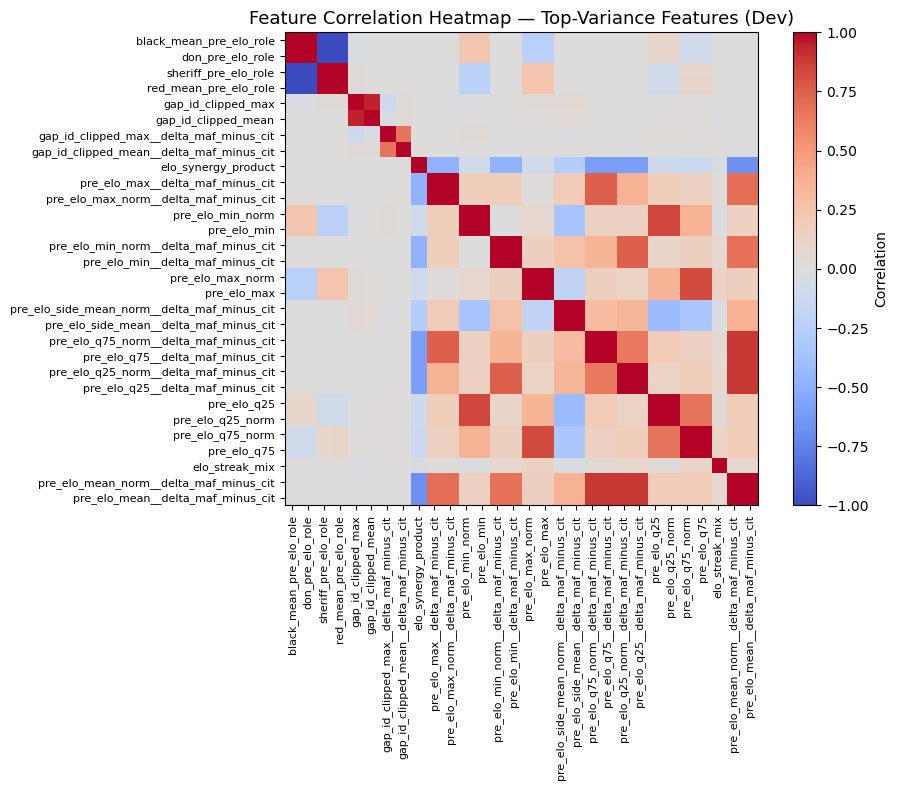

In [20]:
# === DEV AND HOLDOUT SUBSETS (with column names) ===
# reuse existing DataFrame and feature names
X_dev_df = X.loc[~test_mask].copy()
y_dev = y[~test_mask]

X_hold_df = X.loc[test_mask].copy()
y_hold = y[test_mask]

print(f"X_dev_df: {X_dev_df.shape},  y_dev: {y_dev.shape}")
print(f"X_hold_df: {X_hold_df.shape}, y_hold: {y_hold.shape}")

var = X_dev_df.var().sort_values(ascending=False)
top_k = min(30, len(var))
top_cols = var.index[:top_k]

# Compute correlation on those features
corr = X_dev_df[top_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.xticks(range(top_k), top_cols, rotation=90, fontsize=8)
plt.yticks(range(top_k), top_cols, fontsize=8)
plt.title("Feature Correlation Heatmap — Top-Variance Features (Dev)", fontsize=13)
plt.tight_layout()
plt.show()

## 5) Baseline Model

### 5.1 Baseline — Logistic Regression

A simple baseline using standardized features.  
We fit on **Inner-Train** and calibrate on **Calibration**.


In [21]:
# Fit baseline on inner train
logit = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=200, random_state=SEED))
logit.fit(X_tr, y_tr)

# Calibrate baseline on calibration set (Platt scaling)
logit_cal = CalibratedClassifierCV(logit, cv="prefit", method="sigmoid")
logit_cal.fit(X_cal, y_cal)

# Evaluate on holdout
p_logit = logit_cal.predict_proba(X_hold)[:, 1]
m_logit = print_metrics("Baseline (Logistic, calibrated) — Holdout", y_hold, p_logit)


Baseline (Logistic, calibrated) — Holdout
LogLoss: 0.6796045006
AUC: 0.5912143682
Brier: 0.2432618380



c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


## 6) LightGBM (Tuned)

Gradient boosting on decision trees is strong for tabular data.  
We use your tuned parameters and **early stopping** on a small validation slice inside Inner-Train (time-aware).
Then we calibrate on the **Calibration** set.


In [ ]:
# 1) Normalize types
#    - If X_tr is a DataFrame, reset its index to 0..n-1 so iloc works cleanly.
#    - y_tr becomes a 1D NumPy array.
if hasattr(X_tr, "iloc"):
    X_tr_df = X_tr.reset_index(drop=True)
else:
    # convert to DataFrame so we can use iloc below
    X_tr_df = pd.DataFrame(X_tr)

y_tr_arr = np.asarray(y_tr).reshape(-1)

n_tr = len(y_tr_arr)
# 2) Choose an inner validation size (last 15% of X_tr)
n_val = max(int(0.15 * n_tr), 1)
idx_fit = np.arange(0, n_tr - n_val)
idx_val = np.arange(n_tr - n_val, n_tr)

# 3) Row-based slicing (NO column KeyError)
X_fit = X_tr_df.iloc[idx_fit]
y_fit = y_tr_arr[idx_fit]
X_val = X_tr_df.iloc[idx_val]
y_val = y_tr_arr[idx_val]

print(f"Inner fit size: {X_fit.shape}, Inner val size: {X_val.shape}")

# 4) Train LightGBM with early stopping on the inner validation
lgb_params_tuned = {
    'n_estimators': 5000,
    'learning_rate': 0.02,
    'num_leaves': 78,
    'min_data_in_leaf': 134,
    'subsample': 0.8140936140036887,
    'colsample_bytree': 0.7844939514101106,
    'reg_lambda': 0.1904075276204348,
    'reg_alpha': 0.5453556057858624,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'random_state': 42,
}

lgb = LGBMClassifier(**lgb_params_tuned)
lgb.fit(
    X_fit, y_fit,
    eval_set=[(X_val, y_val)],
    eval_metric="logloss",
    callbacks=[early_stopping(stopping_rounds=100), log_evaluation(200)]
)

print("LGBM fitted. best_iteration_:", getattr(lgb, "best_iteration_", None))

# Calibrate on the calibration set
lgb_cal = CalibratedClassifierCV(lgb, cv="prefit", method="sigmoid")
lgb_cal.fit(X_cal, y_cal)

# Evaluate on holdout
p_lgb = lgb_cal.predict_proba(X_hold)[:, 1]
m_lgb = print_metrics("LGBM (calibrated) — Holdout", y_hold, p_lgb)


Inner fit size: (116008, 105), Inner val size: (20472, 105)
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Info] Number of positive: 58004, number of negative: 58004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15072
[LightGBM] [Info] Number of data points in the train set: 116008, number of used features: 88
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 100 rounds
[200]	valid_0's binary_logloss: 0.669311
[400]	valid_0's binary_l

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


## 7) CatBoost (Tuned)


CatBoost is another gradient boosting library with strong defaults.  
We train on **Inner-Train** with early stopping, then calibrate on **Calibration**.


In [23]:
cat = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="Logloss",
    iterations=2000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=7,
    random_seed=SEED,
    subsample=1.0,
    bagging_temperature=1.0,
    od_type="Iter",
    verbose=200
)
cat.fit(
    X_tr, y_tr,
    eval_set=(X_cal, y_cal),
    use_best_model=True
)
print("CatBoost fitted.")

cat_cal = CalibratedClassifierCV(cat, cv="prefit", method="sigmoid")
cat_cal.fit(X_cal, y_cal)

p_cat = cat_cal.predict_proba(X_hold)[:, 1]
m_cat = print_metrics("CatBoost (calibrated) — Holdout", y_hold, p_cat)


0:	learn: 0.6919463	test: 0.6920186	best: 0.6920186 (0)	total: 188ms	remaining: 6m 16s
200:	learn: 0.6596587	test: 0.6633509	best: 0.6633509 (200)	total: 5.03s	remaining: 45s
400:	learn: 0.6507895	test: 0.6552645	best: 0.6552645 (400)	total: 9.73s	remaining: 38.8s
600:	learn: 0.6402119	test: 0.6453707	best: 0.6453707 (600)	total: 14.4s	remaining: 33.4s
800:	learn: 0.6304869	test: 0.6360203	best: 0.6360203 (800)	total: 19s	remaining: 28.5s
1000:	learn: 0.6215074	test: 0.6271526	best: 0.6271526 (1000)	total: 23.7s	remaining: 23.6s
1200:	learn: 0.6127593	test: 0.6185208	best: 0.6185208 (1200)	total: 28.4s	remaining: 18.9s
1400:	learn: 0.6039620	test: 0.6098669	best: 0.6098669 (1400)	total: 33.1s	remaining: 14.1s
1600:	learn: 0.5956312	test: 0.6017394	best: 0.6017394 (1600)	total: 37.8s	remaining: 9.42s
1800:	learn: 0.5873829	test: 0.5935984	best: 0.5935984 (1800)	total: 42.6s	remaining: 4.7s
1999:	learn: 0.5794753	test: 0.5857961	best: 0.5857961 (1999)	total: 47.3s	remaining: 0us

bestTes

c:\Users\user\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


## 8) Model Blending

We blend the calibrated probabilities:  
\( p_{blend} = w \cdot p_{LGBM} + (1-w) \cdot p_{Cat} \)

We search `w ∈ [0,1]` to minimize **Holdout LogLoss**.


In [24]:
ws = np.linspace(0, 1, 41)
best = (999, None)
records = []

for w in ws:
    p_blend = w * p_lgb + (1 - w) * p_cat
    ll = log_loss(y_hold, p_blend)
    records.append((w, ll))
    if ll < best[0]:
        best = (ll, w)

best_ll, best_w = best
p_blend_best = best_w * p_lgb + (1 - best_w) * p_cat
m_blend = metrics_all(y_hold, p_blend_best)

print(f"Best blend (LGBM vs Cat): w_lgbm={best_w:.2f}, w_cat={1-best_w:.2f}")
print(f"→ LogLoss={m_blend['LogLoss']:.6f}  AUC={m_blend['AUC']:.6f}  Brier={m_blend['Brier']:.6f}")


Best blend (LGBM vs Cat): w_lgbm=0.98, w_cat=0.02
→ LogLoss=0.666242  AUC=0.630587  Brier=0.236890


## 9) Plots for the Report

### 9.1 ROC Curves

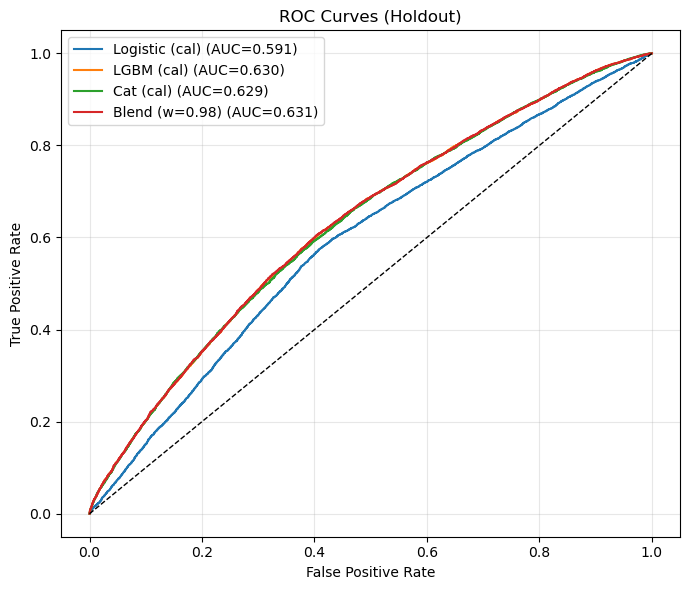

In [25]:
def plot_roc_curves(y_true, probs_dict):
    plt.figure(figsize=(7,6))
    for name, p in probs_dict.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        auc = roc_auc_score(y_true, p)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Holdout)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_roc_curves(
    y_hold,
    {"Logistic (cal)": p_logit, "LGBM (cal)": p_lgb, "Cat (cal)": p_cat, f"Blend (w={best_w:.2f})": p_blend_best}
)


### 9.2 Calibration Curve

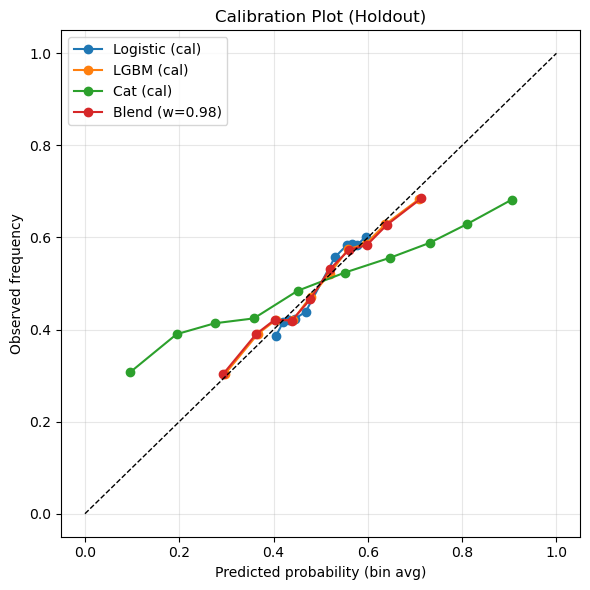

In [26]:
def calibration_curve_bins(y_true, p_prob, n_bins=10):
    # quantile bins for more even population per bin
    quantiles = np.linspace(0, 1, n_bins+1)
    edges = np.quantile(p_prob, quantiles)
    bins = np.digitize(p_prob, edges[1:-1], right=True)
    dfc = pd.DataFrame({"y": y_true, "p": p_prob, "bin": bins})
    grouped = dfc.groupby("bin").agg(obs=("y", "mean"), pred=("p", "mean"), n=("y", "size"))
    return grouped.reset_index(drop=True)

plt.figure(figsize=(6,6))
for name, p in {
    "Logistic (cal)": p_logit,
    "LGBM (cal)": p_lgb,
    "Cat (cal)": p_cat,
    f"Blend (w={best_w:.2f})": p_blend_best
}.items():
    cc = calibration_curve_bins(y_hold, p, n_bins=10)
    plt.plot(cc["pred"], cc["obs"], marker="o", label=name)
plt.plot([0,1], [0,1], "k--", lw=1)
plt.xlabel("Predicted probability (bin avg)")
plt.ylabel("Observed frequency")
plt.title("Calibration Plot (Holdout)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 9.3 Feature Importance (LGBM)

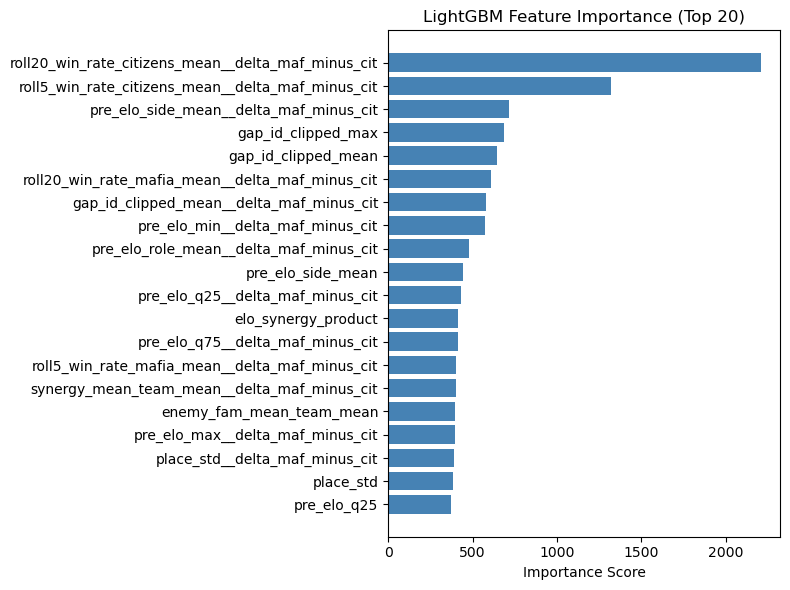

In [27]:
# 1️⃣ Get feature names — reuse from USED_FEATS or model itself
feature_names = list(getattr(lgb, "feature_name_", USED_FEATS))

# 2️⃣ Extract and sort importances
importances = lgb.feature_importances_
order = np.argsort(importances)[::-1]
top = min(20, len(importances))
top_idx = order[:top]

# 3️⃣ Plot horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(np.array(feature_names)[top_idx][::-1], importances[top_idx][::-1], color="steelblue")
plt.title("LightGBM Feature Importance (Top 20)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### 9.4 Metrics Comparison Bar Chart

,Model,LogLoss,AUC,Brier
0,Logistic (cal),0.679605,0.591214,0.243262
1,LGBM (cal),0.666283,0.630173,0.236914
2,Cat (cal),0.737323,0.628950,0.259340
3,Blend (w=0.98),0.666242,0.630587,0.236890


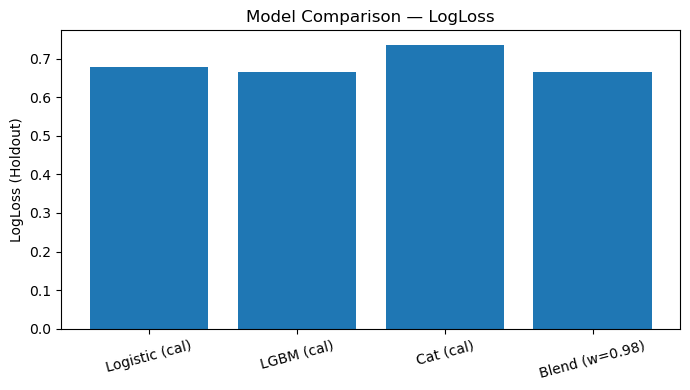

In [28]:
summary = pd.DataFrame([
    {"Model":"Logistic (cal)", "LogLoss": m_logit["LogLoss"], "AUC": m_logit["AUC"], "Brier": m_logit["Brier"]},
    {"Model":"LGBM (cal)",     "LogLoss": m_lgb["LogLoss"],   "AUC": m_lgb["AUC"],   "Brier": m_lgb["Brier"]},
    {"Model":"Cat (cal)",      "LogLoss": m_cat["LogLoss"],   "AUC": m_cat["AUC"],   "Brier": m_cat["Brier"]},
    {"Model":f"Blend (w={best_w:.2f})", "LogLoss": m_blend["LogLoss"], "AUC": m_blend["AUC"], "Brier": m_blend["Brier"]},
])

display(summary)

# bar plot for LogLoss (lower is better)
plt.figure(figsize=(7,4))
plt.bar(summary["Model"], summary["LogLoss"])
plt.xticks(rotation=15)
plt.ylabel("LogLoss (Holdout)")
plt.title("Model Comparison — LogLoss")
plt.tight_layout()
plt.show()
